# Preparing Simulation Data
> Notebook for preparing synthetic datasets. This data will be called as a "raw data" in other notebooks.

In [3]:
from vertex_simulation.primitives import unit_hexagons, VoronoiRegions2Edges, Vertex, Monolayer
from vertex_simulation.simulation import Simulation_Honda, Simulation_Honda_t
import numpy as np
import torch

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

device: cuda
dtype: torch.float32


## Raw Synthetic Dataset

Initialising cell monolayers

In [7]:
v_x,regions = unit_hexagons(4,4) # unit hexagons
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges

m = Monolayer(vertices = Vertex( v_x.copy().tolist(), dtype = dtype), edges = torch.tensor(edge_list), cells = cells)
m.to_(device) # to plot use --> plot_graph_as_quiver(cell_graph)

### Plotting Monolayer Graphs

In [8]:
from vertex_simulation.primitives import plot_graph_as_quiver, graph2networkx_with_pos
import matplotlib.pyplot as plt
import networkx as nx

Using `plot_graph_as_quiver`

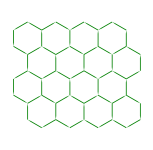

In [9]:
plt.figure(figsize=[2.5,2.5])
plot_graph_as_quiver(m)
plt.axis('equal');

Convert to `networkx.Graph` with `graph2networkx_with_pos` and use `networkx.draw` function

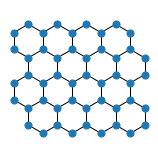

In [12]:
plt.figure(figsize=[2,2])
nx.draw(*graph2networkx_with_pos(m), node_size=50, width=1)
plt.axis('equal');

### Simulation

Prepare an initial state

In [231]:
np.random.seed(42)# np RNG seed
v_x,regions = unit_hexagons(30,30) # unit hexagons
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2 #perturb vertices
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges
# Define cell monolayer
m = Monolayer(vertices = Vertex( v_x.copy().tolist(), dtype = dtype), edges = torch.tensor(edge_list), cells = cells)
m.to_(device) # to plot use --> plot_graph_as_quiver(cell_graph)

Base frequency selection for $cos^2(wt)$:
$$\omega_0 = peaks\_per\_unit\_time \times \pi$$
e.g. for 5 peaks per-unit-time $\omega_0 = 5 \pi$. We can add random number (real number) of peaks to this "base frequency":
```python
omega0 = 5*np.pi # peak_per_unit_time * pi ==> base_frequency
omega = omega0 + 4*np.pi*(torch.randn_like(phases)-0.5) # omega = omega0 +/-2*pi
```

Phases ($\phi$) determine value at $t=0$ for $cos^2(wt+\phi) \in [0,1]$ 
$$\phi \sim Unif(0,\frac{\pi}{2}) $$

In [232]:
torch.manual_seed(0);

p_keep = 0.95
ij_on = 2.5*(torch.rand((len(edge_list),1))< p_keep ).type(dtype).to(device) # 75% of edges are active
phases = np.pi/2*torch.rand((len(edge_list),1)).type(dtype).to(device) # phase => cos^2(phase)@t=0
# phase for cos(wt+phase)^2 can be sample from uniform [0,pi/2) <=> cos^2 \in [1,0)
# omega0 = peak_per_unit_time * pi ==> base_frequency
omega = 5*np.pi + 4*np.pi*(torch.randn_like(phases)-0.5) # omega = omega0 +/-2*pi

def Ka_t(mg,t): return 1.
# def A0_t(mg,t):
#     if t<0.5: C = 1.5
#     else: C = 2.3
#     return C - 1./ (1 + np.exp(20*(t-0.3)) ) 
def A0_t(mg,t):
    return 2.3
def Kp_t(mg,t): return 0.003
def P0_t(mg,t): return 0.
def Lambda_t(mg,t): return ij_on*torch.cos(omega*t+phases)**2

iter:250; t=0.249: E= 3363; max_spd =   4
iter:500; t=0.499: E= 3388; max_spd = 3.9
iter:750; t=0.749: E= 3242; max_spd = 4.8
iter:1000; t=0.999: E= 3237; max_spd = 3.5
iter:1250; t=1.249: E= 3206; max_spd = 5.4
iter:1500; t=1.499: E= 3230; max_spd = 4.8
iter:1750; t=1.749: E= 3195; max_spd =   5
iter:2000; t=1.999: E= 3139; max_spd = 5.1
iter:2250; t=2.249: E= 3242; max_spd = 5.2
iter:2500; t=2.499: E= 3139; max_spd = 4.3
iter:2750; t=2.749: E= 3143; max_spd = 4.8
iter:3000; t=2.999: E= 3080; max_spd = 3.7
iter:3250; t=3.249: E= 3098; max_spd =   4
iter:3500; t=3.499: E= 3150; max_spd =   5
iter:3750; t=3.749: E= 3151; max_spd = 3.8
iter:4000; t=3.999: E= 3161; max_spd =   3
iter:4250; t=4.249: E= 3137; max_spd = 4.9
iter:4500; t=4.499: E= 3089; max_spd =   5
iter:4750; t=4.749: E= 3032; max_spd = 2.9
iter:5000; t=4.999: E= 3145; max_spd = 4.8


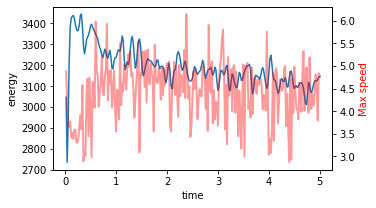

In [233]:
sim_params = {'Ka':Ka_t, 'A0':A0_t, 'Kp':Kp_t, 'P0':P0_t, 'Lambda_ij':Lambda_t}
sim = Simulation_Honda_t(m = m, params = sim_params)

t, verts_t, Energies_maxSpeeds = sim.sample_trajectory(T=5000, delta_T=0.001, sample_freq=20, print_freq=250)

plt.figure(figsize=[5,3])
plt.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[1]);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Max speed',color='red')
ax2.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[2],'r-',alpha=.4,lw=2)
plt.show()

## Saving and Displaying Simulations

**Function for plotting frames** (animation function)

In [11]:
import networkx as nx
from vertex_simulation.primitives import graph2networkx_with_pos
# as a networkx graph
Gnx,pos=graph2networkx_with_pos(m)
def draw_graph(i):
    '''Draw monolayer frames using networkx draw func-n. Assumes. Static graph, i.e. the graph `Gnx` is constant.
    We pass this function to matplotlib.animation obj.'''
    if isinstance(verts_t[i],  torch.Tensor):
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    else:
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i]))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {t[i]:2.3f}')
    nx.draw(Gnx,pos,node_size=5,width=1,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')

### Option 1: HTML video (for displaying) or Save as mp4

Display as HTML video or save as mp4 using matplotlit (+ffmpeg)
```python
import matplotlib.animation as animation
from IPython.display import HTML
# create a figure
fig = plt.figure(figsize=[10,10])
fig.clf()
# display (check your drawing/animation function)
ax = fig.subplots()
ax.axis(False);
draw_graph(0)
plt.show()
plt.close()
# Create an animation
anim = animation.FuncAnimation(fig, draw_graph, interval=200, frames = range(50,len(verts_t)))
# Convert animation to HTML repr-n and display w/ IPython
HTML(anim.to_jshtml()) 
```

### Option 2: Use PIL to save as GIF or TIFF

1. Compile frames:
    ```python
    import PIL
    pil_images=[]
    for i in range(0,len(verts_t),5):
        fig = plt.figure(figsize=[15,15])
        fig.clf()
        ax = fig.subplots()
        ax.axis(False);
        draw_graph(i)
    #     plt.show()
        canvas = plt.get_current_fig_manager().canvas
        canvas.draw()
        pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
        plt.close()
    ```
2. Save as `*.gif` file (alternatively use TIFF):
    ```python
    pil_images[0].save('sim_oscill_2.gif', format='GIF', append_images=pil_images[1:], save_all=True, duration=100, loop=0)
    ```
3. Display using a markdown cell:
    ```
    ![](./sim_oscill_2.gif)
    ```